In [814]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

In [815]:
file_to_read = "../Resources/AviationData_Weather.csv"

data_df = pd.read_csv(file_to_read, encoding='ISO-8859-1', low_memory=False)



data_df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


# Preproccessing

In [816]:

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87282 entries, 0 to 87281
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                87282 non-null  object 
 1   Investigation.Type      87282 non-null  object 
 2   Accident.Number         87282 non-null  object 
 3   Event.Date              87282 non-null  object 
 4   Location                87230 non-null  object 
 5   Country                 87056 non-null  object 
 6   Latitude                33073 non-null  object 
 7   Longitude               33064 non-null  object 
 8   Airport.Code            49322 non-null  object 
 9   Airport.Name            51955 non-null  object 
 10  Injury.Severity         86399 non-null  object 
 11  Aircraft.damage         84272 non-null  object 
 12  Aircraft.Category       30783 non-null  object 
 13  Registration.Number     85965 non-null  object 
 14  Make                    87219 non-null

In [817]:
data_df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,81533.000000,75881.000000,74772.000000,75349.000000,81370.000000
mean,1.147131,0.652772,0.280921,0.360814,5.311847
std,0.447085,5.521338,1.557476,2.257721,27.899156
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


In [818]:
data_df.shape

(87282, 31)

In [819]:
# Keep rows where Investigation.Type = Accident, Country= United States, and Aircraft.Category= Airplane

filtered_df = data_df.loc[(data_df['Aircraft.Category']=='Airplane') & (data_df['Country']== 'United States') & (data_df['Investigation.Type'] == 'Accident')]
filtered_df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.445277,-70.758333,NaN,NaN,...,NaN,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,Personal,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,Business,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,Personal,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983


In [820]:
filtered_df.shape

(22644, 31)

In [821]:
# percent of missing data per column
pct_missing = filtered_df.isnull().mean()

pct_missing_df = pd.DataFrame(pct_missing, columns=['Missing'])
pct_missing_df.sort_values('Missing', ascending = False, inplace = True)

# columns with more than 10% missing values
print(pct_missing_df[pct_missing_df['Missing'] > 0.1])

                         Missing
Schedule                0.933713
Broad.phase.of.flight   0.725314
Air.carrier             0.606474
Airport.Code            0.302288
Airport.Name            0.279456
Longitude               0.143835
Latitude                0.143393
Total.Fatal.Injuries    0.128643
Total.Serious.Injuries  0.127760
Total.Minor.Injuries    0.112568


In [822]:
# Drop columns with 35% missing values or more
dfb = filtered_df.copy()
cols_to_drop = list(pct_missing_df[pct_missing_df['Missing'] > 0.35].index)
dfb.drop(columns = cols_to_drop, axis =1, inplace = True, errors = 'coerce')
print(cols_to_drop)

['Schedule', 'Broad.phase.of.flight', 'Air.carrier']


In [823]:
# Check for duplicate rows
print(dfb.duplicated().sum())

0


In [824]:
# Change dates to datetime remove Cardinal point abb. from lat and lon

dfb.loc[:,'Event.Date'] = pd.to_datetime(dfb['Event.Date'])
dfb.loc[:,'Publication.Date'] = pd.to_datetime(dfb['Publication.Date'])
dfb.loc[:, 'Latitude'] = dfb['Latitude'].str.replace('N|S', '', regex = True)
dfb.loc[:,'Latitude'] = pd.to_numeric(dfb['Latitude'], downcast='float')
dfb.loc[:,'Longitude'] = dfb['Longitude'].str.replace('W|E','', regex= True)
dfb.loc[:,'Longitude'] = pd.to_numeric(dfb['Longitude'], downcast='float')



In [825]:
dfb.sample(10)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Engine.Type,FAR.Description,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status,Publication.Date
85017,20200713X03310,Accident,CEN20LA278,2020-07-10,"Springfield, CO",United States,372635.0,1023652.0,8V7,Springfield Muni,...,Reciprocating,137,Aerial Application,1.0,0.0,0.0,0.0,VMC,NaN,2020-09-26
76398,20150327X81708,Accident,GAA15CA022,2015-03-17,"New Market, IN",United States,395647.0,865537.0,CFJ,CRAWFORDSVILLE MUNI,...,Reciprocating,091,Ferry,0.0,0.0,0.0,2.0,VMC,"The pilot's improper fuel planning, which resu...",2020-09-25
2545,20020917X04007,Accident,NYC82DA212,1982-08-28,"NORWOOD, MA",United States,NaN,NaN,OWD,NORWOOD,...,Reciprocating,Part 91: General Aviation,Instructional,0.0,0.0,0.0,1.0,VMC,Probable Cause,1983-08-28
70756,20110909X00232,Accident,ANC11LA100,2011-09-08,"Galena, AK",United States,644410.0,1565614.0,NaN,NaN,...,Reciprocating,091,Personal,0.0,0.0,0.0,1.0,VMC,The total loss of engine power for undetermine...,2020-09-25
68255,20100604X55138,Accident,ERA10LA296,2010-06-04,"Rainelle, WV",United States,375655.0,804259.0,WV30,Rainelle Airport,...,Reciprocating,091,Personal,0.0,0.0,4.0,0.0,VMC,The pilot's failure to adequately assess the r...,2020-09-25
72548,20120905X42711,Accident,WPR12CA397,2012-09-03,"Spanish Fork, UT",United States,40830.0,1113941.0,U77,Spanish Fork Springvile Metro,...,Reciprocating,091,Personal,0.0,0.0,0.0,2.0,VMC,The pilots failure to maintain directional co...,2020-09-25
64618,20080604X00792,Accident,SEA08FA146,2008-05-30,"Monticello, UT",United States,38616.0,1095147.0,NaN,NaN,...,Reciprocating,135,NaN,2.0,0.0,0.0,0.0,VMC,The in-flight collision with mountainous terra...,2020-09-25
65906,20090204X65300,Accident,CEN09CA151,2009-02-01,"Ferriday, LA",United States,313613.0,914013.0,PVT,Private Airstrip,...,Reciprocating,137,Aerial Application,0.0,0.0,0.0,1.0,VMC,The pilot's loss of control following an impac...,2020-09-25
74131,20130904X93029,Accident,CEN13CA522,2013-08-25,"Iowa City, IA",United States,413823.0,913253.0,KIOW,Iowa City Municipal Airport,...,Reciprocating,091,Personal,0.0,0.0,0.0,1.0,VMC,The pilot failed to maintain directional contr...,2020-09-25
83576,20190716X33934,Accident,GAA19CA423,2019-07-16,"Salmon, ID",United States,44585.0,1144358.0,12ID,Flying B Ranch Landing Strip,...,Reciprocating,091,Instructional,0.0,0.0,0.0,3.0,VMC,The pilot's delayed decision to abort the land...,2020-09-26


In [826]:
# Add year, month, and day columns and limit our DF to year 2000 and after
dfb['Year'] = dfb['Event.Date'].dt.year
dfb['Month'] = dfb['Event.Date'].dt.month_name()
dfb['Day_of_Week'] = dfb['Event.Date'].dt.day_name()
dfb = dfb[dfb['Year'] >= 2000]

# def day_of_week_to_string(day_of_week):
#     if day_of_week == 0:
#         return 'Monday'
#     elif day_of_week == 1:
#         return 'Tuesday'
#     elif day_of_week == 2:
#         return 'Wednesday'
#     elif day_of_week == 3:
#         return 'Thursday'
#     elif day_of_week == 4:
#         return 'Friday'
#     elif day_of_week == 5:
#         return 'Saturday'
#     elif day_of_week == 6:
#         return 'Sunday'

# dfb['Day_of_Week'] = dfb['Day_of_Week'].apply(day_of_week_to_string)
dfb.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status,Publication.Date,Year,Month,Day_of_Week
47743,20001212X20393,Accident,LAX00LA078,2000-01-21,"COMPTON, CA",United States,NaN,NaN,CPM,COMPTON,...,NaN,NaN,1.0,NaN,VMC,Probable Cause,2015-08-16,2000,January,Friday
47864,20001212X20487,Accident,FTW00FA083B,2000-02-16,"MCALESTER, OK",United States,NaN,NaN,MLC,MCALESTER REGIONAL,...,1.0,NaN,NaN,1.0,VMC,Probable Cause,2010-01-28,2000,February,Wednesday
47869,20001212X20487,Accident,FTW00FA083A,2000-02-16,"MCALESTER, OK",United States,NaN,NaN,MLC,MCALESTER REGIONAL,...,1.0,NaN,NaN,1.0,VMC,Probable Cause,2010-01-28,2000,February,Wednesday
47870,20001212X20472,Accident,DCA00MA026,2000-02-16,"RANCHO CORDOVA, CA",United States,NaN,NaN,MHR,Sacramento Mather Airport,...,3.0,NaN,NaN,NaN,VMC,Probable Cause,2009-09-29,2000,February,Wednesday
47876,20001212X20521,Accident,LAX00LA105,2000-02-18,"ELKO, NV",United States,40.816666,-115.791664,NaN,NaN,...,NaN,NaN,1.0,NaN,VMC,Probable Cause,2010-07-15,2000,February,Friday


In [827]:
dfb.dtypes

Event.Id                          object
Investigation.Type                object
Accident.Number                   object
Event.Date                datetime64[ns]
Location                          object
Country                           object
Latitude                         float32
Longitude                        float32
Airport.Code                      object
Airport.Name                      object
Injury.Severity                   object
Aircraft.damage                   object
Aircraft.Category                 object
Registration.Number               object
Make                              object
Model                             object
Amateur.Built                     object
Number.of.Engines                float64
Engine.Type                       object
FAR.Description                   object
Purpose.of.flight                 object
Total.Fatal.Injuries             float64
Total.Serious.Injuries           float64
Total.Minor.Injuries             float64
Total.Uninjured 

In [828]:
# value counts
for col in dfb.columns:
    print(dfb[col].value_counts().nlargest(10))
    print('--------------------------\n')

20071108X01768    2
20010226X00510    2
20080213X00187    2
20061015X01521    2
20070426X00458    2
20050825X01313    2
20060601X00665    2
20070705X00879    2
20070111X00042    2
20051213X01965    2
Name: Event.Id, dtype: int64
--------------------------

Accident    19456
Name: Investigation.Type, dtype: int64
--------------------------

LAX00LA078    1
GAA16CA104    1
GAA16CA109    1
GAA16CA108    1
CEN16FA086    1
CEN16FA087    1
ERA16FA089    1
GAA16CA105    1
CEN16FA083    1
GAA16CA348    1
Name: Accident.Number, dtype: int64
--------------------------

2011-06-18    14
2010-05-29    14
2011-03-19    14
2011-07-23    14
2012-08-31    14
2012-07-21    13
2018-09-01    13
2008-08-02    12
2007-10-07    12
2011-08-13    12
Name: Event.Date, dtype: int64
--------------------------

Anchorage, AK      90
Talkeetna, AK      67
Phoenix, AZ        64
Palmer, AK         64
Fairbanks, AK      62
Atlanta, GA        53
Houston, TX        50
Reno, NV           50
Miami, FL          48
San Ant

In [829]:
dfb.dtypes

Event.Id                          object
Investigation.Type                object
Accident.Number                   object
Event.Date                datetime64[ns]
Location                          object
Country                           object
Latitude                         float32
Longitude                        float32
Airport.Code                      object
Airport.Name                      object
Injury.Severity                   object
Aircraft.damage                   object
Aircraft.Category                 object
Registration.Number               object
Make                              object
Model                             object
Amateur.Built                     object
Number.of.Engines                float64
Engine.Type                       object
FAR.Description                   object
Purpose.of.flight                 object
Total.Fatal.Injuries             float64
Total.Serious.Injuries           float64
Total.Minor.Injuries             float64
Total.Uninjured 

In [830]:
# bucket private and none
# dfb["Airport.Name"] = dfb["Airport.Name"].fillna("Unknown")

dfb["Airport.Name"] = dfb["Airport.Name"].apply(lambda x: "Unknown" if pd.isnull(x) else "Private" if "private" in x.lower() else "Private" if "pvt" in x.lower() else "None" if "none" in x.lower()  else x)
dfb["Airport.Name"] = dfb["Airport.Name"].str.title()
dfb["Airport.Name"].value_counts()

Unknown                           5172
Private                            470
None                                49
Merrill Field                       30
Phoenix Deer Valley                 26
                                  ... 
Mallards Landing Airport             1
Palm Springs Internat'L Airpor       1
County Memorial Airport              1
Park Falls Municipal Airport         1
Ellinwood Muni                       1
Name: Airport.Name, Length: 7691, dtype: int64

In [831]:
for airport_name in dfb["Airport.Name"].sort_values(ascending=True).unique():
  print(airport_name)

12E Airstrip
29 Palms Airport
50S
85Th Avenue Airstrip
A L Mangham Jr Rgnl
A L Mangham Jr. Regional
A R S Sport Strip
A&P Airpark Airport
A.L. Mangham Jr. Regional
Abbeville
Abbeville Municipal Airport
Aberdeen Muni
Aberdeen Regional Airport
Abernathy Airport
Abernathy Fielld
Abernathy Muni
Abilene Municipal
Abilene Regional
Abilene Regional Airport
Abilene Rgnl
Abraham Lincoln Capital
Abraham Lincoln Capital Airpor
Abraham Lincoln Capital Arpt
Abraham Lincoln Capital Arpt.
Abrams Municipal
Acadiana Regional
Accomack County
Accomack County Airport
Ada Regional Airport
Addington Field
Addington Field Airport
Addison
Addison Airport
Adelano Airport
Adelanto
Adirondack Regional Airport
Adrmore Downtown Executive
Aero Acres Airport
Aero Country
Aero Country Airport
Aero Estates
Aero Plantation
Aero Tech Inc. Airport
Aero Valley Airport
Aeroacres
Aeroacres Airport
Aerobatic Practice Airport
Aerobear Field
Aeroflex-Andover
Aeroflex-Andover Airport
Afton
Afton Muni
Afton Municipal Airport
Ag 

In [832]:

# # Load the JSON file
# with open('../airports.json') as json_file:
#      data = json.load(json_file)

# # Create empty lists of standardized airport names, lon, lata
# airport_names = [] 
# lons = []
# lats = []

# # print(data)

# for row in data:
#     # print(data[row])

#     for key in data[row]:
#         # print(key, data[row][key])
#         if key == "name":
#             airport_names.append(data[row][key])
#         elif key == "lon":
#             lons.append(data[row][key])
#         elif key == "lat":
#             lats.append(data[row][key])
#     # print()

# coords = [(lon, lat) for lon, lat in zip(lons, lats)]
# # print(airport_names, lats, lons)
# print(airport_names[:4], coords[:4])

In [833]:
# from fuzzyset import FuzzySet

# fuzzy_set = FuzzySet()

# for word in airport_names:
#     fuzzy_set.add(word)

# for index, row in dfb.iterrows():
#     match = fuzzy_set.get(row["Airport.Name"])
#     if match is not None:
#         dfb.at[index, "Airport.Name"] = match[0]

In [834]:
# # Use ahocorasick lib for matching names


# dfb["Airport.Name"] = dfb["Airport.Name"].astype(str)

# # Create an instance of the automaton
# A = ahocorasick.Automaton()

# # Add patterns to the automaton
# for word in airport_names:
#     A.add_word(word, word)

# # Build the automaton
# A.make_automaton()

# # Search for the patterns in a text
# for index, row in dfb.iterrows():
#     for end_index, value in A.iter(row["Airport.Name"]):
#         start_index = end_index - len(value) + 1
#         print(f'{value} found at {start_index}:{end_index}')
#         dfb.loc[index, "Airport.Name"] = value

In [835]:
for airport_name in dfb["Airport.Name"].sort_values(ascending=True).unique():
  print(airport_name)

12E Airstrip
29 Palms Airport
50S
85Th Avenue Airstrip
A L Mangham Jr Rgnl
A L Mangham Jr. Regional
A R S Sport Strip
A&P Airpark Airport
A.L. Mangham Jr. Regional
Abbeville
Abbeville Municipal Airport
Aberdeen Muni
Aberdeen Regional Airport
Abernathy Airport
Abernathy Fielld
Abernathy Muni
Abilene Municipal
Abilene Regional
Abilene Regional Airport
Abilene Rgnl
Abraham Lincoln Capital
Abraham Lincoln Capital Airpor
Abraham Lincoln Capital Arpt
Abraham Lincoln Capital Arpt.
Abrams Municipal
Acadiana Regional
Accomack County
Accomack County Airport
Ada Regional Airport
Addington Field
Addington Field Airport
Addison
Addison Airport
Adelano Airport
Adelanto
Adirondack Regional Airport
Adrmore Downtown Executive
Aero Acres Airport
Aero Country
Aero Country Airport
Aero Estates
Aero Plantation
Aero Tech Inc. Airport
Aero Valley Airport
Aeroacres
Aeroacres Airport
Aerobatic Practice Airport
Aerobear Field
Aeroflex-Andover
Aeroflex-Andover Airport
Afton
Afton Muni
Afton Municipal Airport
Ag 

In [836]:
# "Anchorage, AK" Split 'Location' in City and State
dfb['Location'] = dfb['Location'].str.replace(',', ', ')
dfb[['City','State']] = dfb['Location'].str.split(', ', n=1, expand=True)
dfb['City'] = dfb['City'].str.title()
dfb[['City','State']]

,City,State
47743,Compton,CA
47864,Mcalester,OK
47869,Mcalester,OK
47870,Rancho Cordova,CA
47876,Elko,NV
...,...,...
87264,South Bend,IN
87265,Ellinwood,KS
87270,Ivanhoe,CA
87271,Houston,TX


In [837]:
# Combine same Makes 
dfb["Make"] = dfb["Make"].str.title()


In [838]:
for make in dfb['Make'].unique():
  print(make)

dfb['Make'].nunique()

Myers
Cessna
Douglas
Ayres
Boeing
Learjet
Steel/Vans
Schweizer
Beech
Mcdonnell Douglas
Dassault-Breguet
Meshko Zenair
Piper
De Havilland
Henry
Bennett
Moravan
Taylorcraft
Schuchart
Edge
Thomson
Rans, Inc.
Swearingen
Ercoupe
Waco
Grenier
Gulfstream American
Aero Commander
Baughman
Grumman
Bilgri
Eckstein
Air Tractor
Giroux
Grumman American
Crawford
Bellanca
Tomash
Beechcraft
Ercoupe (Eng & Research Corp.)
Aviat
Mooney
Consolidated Aeronautics Inc.
Carlisle
Maule
Mathews
Larry Woods
Socata
Wsk Pzl Mielec
Ayers
Kolb Company
Stinson
Maysmike
Diamond Aircraft Industries
Aircraft Mfg & Dev. Co. (Amd)
Lancair
Kucklick
Fairchild
Unknown
Wells
Starduster
Williams
Lockheed
Price
Lake
American General Aircraft
Howard Aircraft Corp.
Velocity
Avions Max Holste
Cleveland Orson
William F. Lair
R. James Thorne
Globe
Clement-Kazmierczak
Luscombe
Fleet
American Champion (Acac)
Danbrook
Jerry Garrison
Menefee
Rockwell
Dantzer Lawrence L
Yakovlev
Aeronca
Andrews
Bolger Scott
Sawyer
Villeneuve
Fraker
Loehl

3119

In [839]:
most_common_make = dfb['Make'].value_counts().nlargest(30)
most_common_make

Cessna                            6002
Piper                             3381
Beech                             1182
Mooney                             314
Boeing                             288
Bellanca                           209
Maule                              198
Air Tractor Inc                    196
Aeronca                            182
Cirrus Design Corp                 170
Air Tractor                        170
Champion                           146
Luscombe                           134
Grumman                            126
Stinson                            124
Vans                               102
North American                      95
Cirrus                              88
Taylorcraft                         85
Dehavilland                         80
Aero Commander                      75
Aviat Aircraft Inc                  70
Aviat                               67
Diamond Aircraft Ind Inc            63
Grumman Acft Eng Cor-Schweizer      58
Socata                   

In [840]:
# combine registration labels
dfb['Registration.Number'] = dfb['Registration.Number'].apply(lambda x: "Unknown" if pd.isnull(x) else "NONE" if "none" in x.lower() else "UNREG" if "unreg" in x.lower() else x)

In [841]:
dfb['Registration.Number'].value_counts().nlargest(10)

UNREG     60
NONE      16
N8402K     5
N5408Y     4
N323KT     4
N99HV      4
N65645     3
N460CT     3
N185DK     3
N8376K     3
Name: Registration.Number, dtype: int64

In [842]:
for registration in dfb['Registration.Number'].unique():
  print(registration)

N813S
N9505B
N91994
N8079U
N4011Y
N668SW
N86BE
N522SW
N64ME
N3629D
N806BF
EI-CRL
N155DL
N5883B
N1DC
N17AE
N3735D
N802US
N59CF
N4386W
N2507X
N9277X
N7640P
N120BA
N696DH
N262MM
N241GS
N125PM
N8253W
N526GC
N5142D
N4418U
N325HP
N7202E
N63351
N4795D
N612UA
N39945
N3862D
N541TW
N325L
N1173R
N6134A
N7427J
N556UP
N87WW
N509R
N754NW
N4642J
N9454J
N5079J
N4090D
N94769
NC662Y
N140NJ
N1419
N3545R
N52WP
N7744B
N358RW
N7791V
N290KB
N6912S
N4866Q
N623U
N1373E
N9B
N747BS
N6321B
N2326S
N1029G
N81310
N3R
N7634Z
N8851V
N7300R
N369AF
N6688D
N9855S
N2601N
N3989H
N2870S
N6QR
N21689
N5337B
N5556Q
N3345Y
N847EX
N1302D
N5244D
N878A
N5066M
N4794P
N6193V
N402ME
N2585B
N9852J
N1122Y
N752CF
N628
N5629G
N944FE
N9973H
N132JH
N219ME
N366X
N613SP
N4413C
N405BM
N2535R
CGDJF
N757AZ
N705QD
N175W
N82204
N76494
N258P
N221SA
N1156N
N55175
N211EZ
N82946
NONE
N759XA
N4903F
N53352
N2279Y
N9298D
N8548S
N7342G
N555MR
N930TG
N4506L
N2825X
N4133Y
N7501H
N6216M
N540Q
N279WP
N70LB
N410GV
N787WW
N33WL
N83272
N25SF
N905CT
N299KP
N758L

In [843]:
# Change to 0 and 1 in case data is used for machine learning
dfb['Amateur.Built'] = dfb['Amateur.Built'].map({'Yes': 1, 'No': 0, 'Y': 1, 'N':0})
dfb['Amateur.Built'].value_counts()

0.0    16682
1.0     2772
Name: Amateur.Built, dtype: int64

In [844]:
# Combine injury values
dfb['Injury.Severity'] = dfb['Injury.Severity'].str.split('(').str[0]
dfb['Injury.Severity'].fillna('Unknown')

47743    Non-Fatal
47864        Fatal
47869        Fatal
47870        Fatal
47876    Non-Fatal
           ...    
87264    Non-Fatal
87265    Non-Fatal
87270    Non-Fatal
87271    Non-Fatal
87277        Fatal
Name: Injury.Severity, Length: 19456, dtype: object

In [845]:
dfb['Injury.Severity'].value_counts()

Non-Fatal    16407
Fatal         3018
Name: Injury.Severity, dtype: int64

In [846]:
# Check weather conditions column
dfb.loc[:,'Weather.Condition'] = dfb['Weather.Condition'].replace({'Unk': 'UNK'})
dfb['Weather.Condition'].value_counts()

VMC    18178
IMC      910
UNK       82
Name: Weather.Condition, dtype: int64

In [847]:
dfb = dfb.dropna(subset=["Weather.Condition"])

In [848]:
# Add a seasons column
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Autum'
    
dfb.loc[:,'Season'] = dfb["Event.Date"].dt.month.apply(assign_season)

In [849]:
dfb['Report.Status'].dtype

dtype('O')

In [850]:
dfb["Report.Status"].isna().sum()

1232

In [855]:
dfb.dropna(subset=["Report.Status"], inplace=True)

In [862]:
for reports in dfb["Report.Status"]:
    print(reports)

Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable Cause
Probable C

In [856]:
pilot_error = dfb[dfb["Report.Status"].str.contains('pilot', case=False)]
pilot_error

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Uninjured,Weather.Condition,Report.Status,Publication.Date,Year,Month,Day_of_Week,City,State,Season
63913,20080107X00026,Accident,SEA08LA057,2008-01-01,"Sonoma, CA",United States,381326.0,1222659.0,OQ3,Schellville/Sonoma,...,3.0,VMC,The departing pilot's inadequate visual lookout.,2020-09-25,2008,January,Tuesday,Sonoma,CA,Winter
63914,20080109X00036,Accident,DFW08CA054,2008-01-01,"Arcola, TX",United States,293022.0,952836.0,AXH,Houston-Southwest,...,1.0,VMC,The pilot's failure to maintain directional co...,2020-09-25,2008,January,Tuesday,Arcola,TX,Winter
63915,20080115X00051,Accident,DEN08CA047,2008-01-02,"Loveland, CO",United States,40276.0,10504.0,FNL,Fort Collins Loveland,...,1.0,VMC,the student pilot's premature flare resulting ...,2020-09-25,2008,January,Wednesday,Loveland,CO,Winter
63916,20080210X00166,Accident,NYC08CA074,2008-01-02,"Brunswick, GA",United States,3196.0,812328.0,SSI,Malcolm Mckinnon Airport,...,3.0,VMC,The pilot's inadequate compensation for wind c...,2020-09-25,2008,January,Wednesday,Brunswick,GA,Winter
63921,20080115X00047,Accident,MIA08LA035,2008-01-05,"Spotsylvania, VA",United States,38128.0,773515.0,NaN,Unknown,...,0.0,VMC,The pilot's failure to follow the checklist an...,2020-09-25,2008,January,Saturday,Spotsylvania,VA,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86902,20210916103885,Accident,WPR21LA347,2021-09-15,"Stanley, ID",United States,441231.0,114564.0,2U7,Stanley,...,1.0,VMC,The pilots failure to maintain airplane contr...,2021-11-16,2021,September,Wednesday,Stanley,ID,Autum
86906,20210916103892,Accident,CEN21LA422,2021-09-16,"Ypsilanti, MI",United States,421418.0,833218.0,YIP,Willow Run,...,1.0,VMC,The pilots failure to maintain directional co...,2021-11-16,2021,September,Thursday,Ypsilanti,MI,Autum
86909,20210920103910,Accident,CEN21LA430,2021-09-16,"Battle Creek, MI",United States,421827.0,85155.0,BTL,Battle Creek Exec At Kellogg F,...,2.0,VMC,The pilots failure to maintain directional co...,2021-11-16,2021,September,Thursday,Battle Creek,MI,Autum
86917,20210927103966,Accident,CEN21LA453,2021-09-17,"Osage Beach, MO",United States,38639.0,924051.0,K15,Grand Glaize-Osage Beach,...,2.0,VMC,The pilot and flight instructors failure to e...,2021-11-16,2021,September,Friday,Osage Beach,MO,Autum


In [868]:
cause_weather = dfb[dfb["Report.Status"].str.contains('weather|climate', case=False)]
cause_weather

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Uninjured,Weather.Condition,Report.Status,Publication.Date,Year,Month,Day_of_Week,City,State,Season
64006,20080312X00303,Accident,MIA08CA049,2008-01-30,"Jefferson, GA",United States,341019.0,833338.0,19A,Jackson County Airport,...,0.0,VMC,The failure of the pilot-in-command to maintai...,2020-09-25,2008,January,Wednesday,Jefferson,GA,Winter
64088,20080220X00216,Accident,DEN08FA059,2008-02-17,"Benton, KS",United States,374715.0,97732.0,1K1,Lloyd Stearman Field Airport,...,0.0,IMC,The pilot's failure to maintain clearance from...,2020-09-25,2008,February,Sunday,Benton,KS,Winter
64106,20080228X00245,Accident,SEA08LA082,2008-02-22,"Kayenta, AZ",United States,362818.0,110254.0,38AZ,Peabody Bedard Field,...,15.0,IMC,The flight crew's failure to execute a missed ...,2020-09-25,2008,February,Friday,Kayenta,AZ,Winter
64155,20080610X00818,Accident,ANC08LA039,2008-03-04,"Nikolai, AK",United States,62320.0,153370.0,NaN,Unknown,...,2.0,VMC,The flight instructor's inadequate evaluation ...,2020-09-25,2008,March,Tuesday,Nikolai,AK,Spring
64228,20080415X00485,Accident,LAX08CA084,2008-03-22,"Honolulu, HI",United States,21197.0,1575521.0,PHNL,Honolulu International Airport,...,4.0,VMC,The pilot's inadequate compensation for the wi...,2020-09-25,2008,March,Saturday,Honolulu,HI,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83400,20190620X80853,Accident,CEN19FA177,2019-06-20,"Elida, OH",United States,405047.0,84930.0,NaN,Unknown,...,0.0,IMC,The noninstrument-rated pilot's decision to co...,2020-09-26,2019,June,Thursday,Elida,OH,Summer
83421,20190708X24735,Accident,CEN19LA213,2019-06-22,"Smithfield, RI",United States,415447.0,71297.0,SFZ,North Central State Airport,...,1.0,VMC,The pilots failure to use carburetor heat on ...,2020-03-12,2019,June,Saturday,Smithfield,RI,Summer
84057,20191016X21654,Accident,ANC20LA002,2019-10-13,"Palmer, AK",United States,61271.0,148410.0,NaN,Unknown,...,1.0,VMC,The pilot's delayed application of carburetor ...,2020-11-19,2019,October,Sunday,Palmer,AK,Autum
85632,20201215102416,Accident,CEN21LA087,2020-11-23,"Gilliam, LA",United States,324925.0,935042.0,NaN,Unknown,...,1.0,UNK,The non-instrument rated pilots encounter wit...,2021-08-31,2020,November,Monday,Gilliam,LA,Autum


In [870]:
for report in cause_weather["Report.Status"]:
    print(report)

The failure of the pilot-in-command to maintain control of the airplane and his poor weather evaluation before attempting to taxi the airplane. A factor in the accident was the failure of airport personnel to correct the inaccurate wind information reported by the AWOS.
The pilot's failure to maintain clearance from the trees. Contributing to the accident was the pilot's flight into known adverse weather conditions and the low clouds and visibility.
The flight crew's failure to execute a missed approach, which resulted in a runway excursion after landing. Contributing to the accident were the inoperative lights, weather conditions below published approach minimums, and the slush contaminated runway.
The flight instructor's inadequate evaluation of  the weather conditions. Contributing to the accident was an inadvertent stall/mush.
The pilot's inadequate compensation for the wind conditions and his subsequent failure to maintain an adequate airspeed during landing. A contributing factor

In [698]:
# Change to str because some values are floats 
dfb["Report.Status"] = dfb["Report.Status"].astype(str)

In [699]:
# search for the word "landing", "pilot", "failure", "control",... in the report.status col
words = ['pilot', 'failure', 'control', "misjudged", "inadequate", "impairment", "incapacitation", "excessive", "improper","mismanagement","inability"]

filtered_reports = dfb['Report.Status'].apply(lambda x: any(word.lower() in x.lower() for word in words))

reports_landing = dfb[filtered_reports]

reports_landing

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Uninjured,Weather.Condition,Report.Status,Publication.Date,Year,Month,Day_of_Week,City,State,Season
63913,20080107X00026,Accident,SEA08LA057,2008-01-01,"Sonoma, CA",United States,381326.0,1222659.0,OQ3,Schellville/Sonoma,...,3.0,VMC,The departing pilot's inadequate visual lookout.,2020-09-25,2008,January,Tuesday,Sonoma,CA,Winter
63914,20080109X00036,Accident,DFW08CA054,2008-01-01,"Arcola, TX",United States,293022.0,952836.0,AXH,Houston-Southwest,...,1.0,VMC,The pilot's failure to maintain directional co...,2020-09-25,2008,January,Tuesday,Arcola,TX,Winter
63915,20080115X00051,Accident,DEN08CA047,2008-01-02,"Loveland, CO",United States,40276.0,10504.0,FNL,Fort Collins Loveland,...,1.0,VMC,the student pilot's premature flare resulting ...,2020-09-25,2008,January,Wednesday,Loveland,CO,Winter
63916,20080210X00166,Accident,NYC08CA074,2008-01-02,"Brunswick, GA",United States,3196.0,812328.0,SSI,Malcolm Mckinnon Airport,...,3.0,VMC,The pilot's inadequate compensation for wind c...,2020-09-25,2008,January,Wednesday,Brunswick,GA,Winter
63917,20080107X00027,Accident,DFW08LA055,2008-01-03,"Oklahoma City, OK",United States,35321.0,973829.0,PWA,Wiley Post,...,8.0,VMC,The line technician's failure to remain clear ...,2020-09-25,2008,January,Thursday,Oklahoma City,OK,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86902,20210916103885,Accident,WPR21LA347,2021-09-15,"Stanley, ID",United States,441231.0,114564.0,2U7,Stanley,...,1.0,VMC,The pilots failure to maintain airplane contr...,2021-11-16,2021,September,Wednesday,Stanley,ID,Autum
86906,20210916103892,Accident,CEN21LA422,2021-09-16,"Ypsilanti, MI",United States,421418.0,833218.0,YIP,Willow Run,...,1.0,VMC,The pilots failure to maintain directional co...,2021-11-16,2021,September,Thursday,Ypsilanti,MI,Autum
86909,20210920103910,Accident,CEN21LA430,2021-09-16,"Battle Creek, MI",United States,421827.0,85155.0,BTL,Battle Creek Exec At Kellogg F,...,2.0,VMC,The pilots failure to maintain directional co...,2021-11-16,2021,September,Thursday,Battle Creek,MI,Autum
86917,20210927103966,Accident,CEN21LA453,2021-09-17,"Osage Beach, MO",United States,38639.0,924051.0,K15,Grand Glaize-Osage Beach,...,2.0,VMC,The pilot and flight instructors failure to e...,2021-11-16,2021,September,Friday,Osage Beach,MO,Autum


In [700]:
# Dropping columns and changing '.' to '_'
cols_to_drop = ['Event.Id', 'Accident.Number','Location','Total.Fatal.Injuries',
                'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']

dfb = dfb.drop(columns = cols_to_drop)
    
dfb.columns = dfb.columns.str.replace('.', '_')

dfb.head()

C:\Users\wero\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


,Investigation_Type,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,Injury_Severity,Aircraft_damage,Aircraft_Category,...,Purpose_of_flight,Weather_Condition,Report_Status,Publication_Date,Year,Month,Day_of_Week,City,State,Season
47743,Accident,2000-01-21,United States,NaN,NaN,CPM,Compton,Non-Fatal,Substantial,Airplane,...,Personal,VMC,Probable Cause,2015-08-16,2000,January,Friday,Compton,CA,Winter
47864,Accident,2000-02-16,United States,NaN,NaN,MLC,Mcalester Regional,Fatal,Substantial,Airplane,...,Unknown,VMC,Probable Cause,2010-01-28,2000,February,Wednesday,Mcalester,OK,Winter
47869,Accident,2000-02-16,United States,NaN,NaN,MLC,Mcalester Regional,Fatal,Destroyed,Airplane,...,Personal,VMC,Probable Cause,2010-01-28,2000,February,Wednesday,Mcalester,OK,Winter
47870,Accident,2000-02-16,United States,NaN,NaN,MHR,Sacramento Mather Airport,Fatal,Destroyed,Airplane,...,NaN,VMC,Probable Cause,2009-09-29,2000,February,Wednesday,Rancho Cordova,CA,Winter
47876,Accident,2000-02-18,United States,40.816666,-115.791664,NaN,Unknown,Non-Fatal,Substantial,Airplane,...,Positioning,VMC,Probable Cause,2010-07-15,2000,February,Friday,Elko,NV,Winter


In [701]:
dfb.columns

Index(['Investigation_Type', 'Event_Date', 'Country', 'Latitude', 'Longitude',
       'Airport_Code', 'Airport_Name', 'Injury_Severity', 'Aircraft_damage',
       'Aircraft_Category', 'Registration_Number', 'Make', 'Model',
       'Amateur_Built', 'Number_of_Engines', 'Engine_Type', 'FAR_Description',
       'Purpose_of_flight', 'Weather_Condition', 'Report_Status',
       'Publication_Date', 'Year', 'Month', 'Day_of_Week', 'City', 'State',
       'Season'],
      dtype='object')

In [702]:
rearrange_cols = ['Investigation_Type','Event_Date','Year','Month','Season', 'Day_of_Week','Country',
                  'State','Injury_Severity','Aircraft_damage','Airport_Name','Airport_Code',
                  'Aircraft_Category','Registration_Number','Make','Model', 'Amateur_Built',
                  'Number_of_Engines','Engine_Type','FAR_Description', 'Purpose_of_flight',
                  'Weather_Condition','Report_Status', 'Publication_Date']

clean_aviation_df = dfb[rearrange_cols]
clean_aviation_df.drop_duplicates()
clean_aviation_df.head()

,Investigation_Type,Event_Date,Year,Month,Season,Day_of_Week,Country,State,Injury_Severity,Aircraft_damage,...,Make,Model,Amateur_Built,Number_of_Engines,Engine_Type,FAR_Description,Purpose_of_flight,Weather_Condition,Report_Status,Publication_Date
47743,Accident,2000-01-21,2000,January,Winter,Friday,United States,CA,Non-Fatal,Substantial,...,Myers,Q-2,1.0,1.0,Reciprocating,Part 91: General Aviation,Personal,VMC,Probable Cause,2015-08-16
47864,Accident,2000-02-16,2000,February,Winter,Wednesday,United States,OK,Fatal,Substantial,...,Cessna,208B,0.0,1.0,Turbo Prop,Part 135: Air Taxi & Commuter,Unknown,VMC,Probable Cause,2010-01-28
47869,Accident,2000-02-16,2000,February,Winter,Wednesday,United States,OK,Fatal,Destroyed,...,Cessna,182M,0.0,1.0,Reciprocating,Part 91: General Aviation,Personal,VMC,Probable Cause,2010-01-28
47870,Accident,2000-02-16,2000,February,Winter,Wednesday,United States,CA,Fatal,Destroyed,...,Douglas,DC-8-71F,0.0,4.0,Turbo Fan,Part 121: Air Carrier,NaN,VMC,Probable Cause,2009-09-29
47876,Accident,2000-02-18,2000,February,Winter,Friday,United States,NV,Non-Fatal,Substantial,...,Ayres,NaN,0.0,1.0,NaN,Part 91: General Aviation,Positioning,VMC,Probable Cause,2010-07-15


In [703]:
clean_aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19170 entries, 47743 to 87265
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Investigation_Type   19170 non-null  object        
 1   Event_Date           19170 non-null  datetime64[ns]
 2   Year                 19170 non-null  int64         
 3   Month                19170 non-null  object        
 4   Season               19170 non-null  object        
 5   Day_of_Week          19170 non-null  object        
 6   Country              19170 non-null  object        
 7   State                19170 non-null  object        
 8   Injury_Severity      19147 non-null  object        
 9   Aircraft_damage      18942 non-null  object        
 10  Airport_Name         19170 non-null  object        
 11  Airport_Code         14035 non-null  object        
 12  Aircraft_Category    19170 non-null  object        
 13  Registration_Number  19170 

In [704]:
clean_aviation_df.to_csv('../Resources/clean_aviation_weather.csv')

In [705]:
# color gradient source:https://medium.com/@BrendanArtley/matplotlib-color-gradients-21374910584b

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

# Analysis

* What seasons are most commonly associated with aviation accidents?

* How does the frequency of aviation accidents vary with different weather conditions?

* Are certain types of aircraft more prone to accidents in certain weather conditions?

* Are there certain geographical regions that are more prone to aviation accidents due to weather conditions?

* What role do human factors, such as pilot error or inadequate training, play in aviation accidents that are caused by adverse weather conditions?

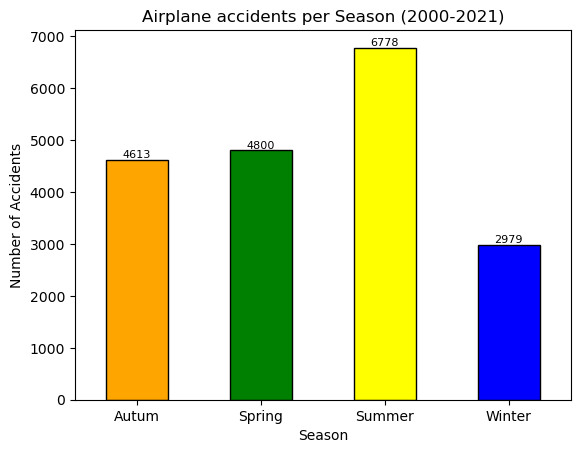

In [857]:
# What types of weather conditions are most commonly associated with aviation accidents?

accidents_per_season = clean_aviation_df.groupby(['Season'])['Event_Date'].count()

colors = ['orange','green','yellow','blue']

ax = accidents_per_season.plot(kind='bar', color=colors, edgecolor='black' )

for i in ax.containers:
    ax.bar_label(i, fontsize=8)

plt.xticks(rotation=0)
plt.xlabel('Season')
plt.ylabel('Number of Accidents')
plt.title('Airplane accidents per Season (2000-2021)')
plt.savefig('../Images/accidents_per_season.png')


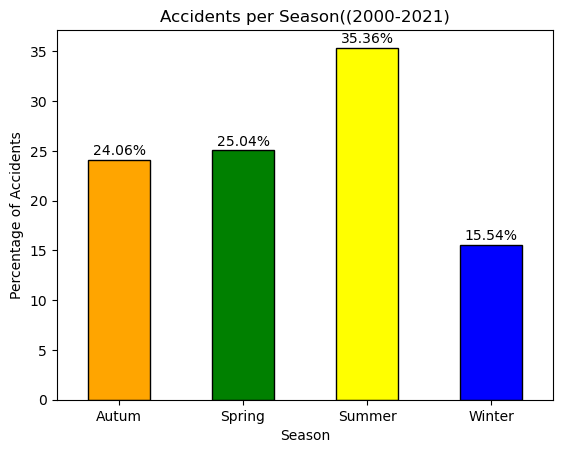

In [858]:
total_accidents = accidents_per_season.sum()
accidents_per_season_pct = accidents_per_season/total_accidents*100

colors = ['orange','green','yellow','blue']

ax = accidents_per_season_pct.plot(kind='bar', color=colors, edgecolor='black')

for i, v in enumerate(accidents_per_season_pct):
    ax.text(i, v+0.5, f"{v:.2f}%", ha='center')

plt.xticks(rotation=0)
plt.xlabel('Season')
plt.ylabel('Percentage of Accidents')
plt.title('Accidents per Season((2000-2021)')
plt.savefig('../Images/accidents_per_season_pct.png')


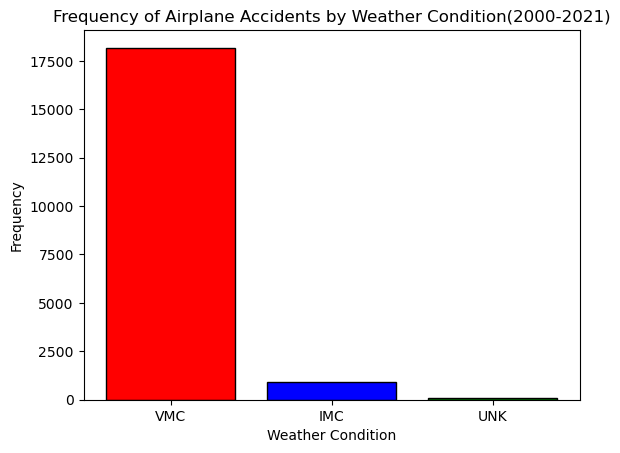

In [708]:
# How does the frequency of aviation accidents vary with different weather conditions?

weather_counts = clean_aviation_df['Weather_Condition'].value_counts()

colors = ['red','blue', 'green']

plt.bar(weather_counts.index, weather_counts.values, color=colors, edgecolor='black')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.title('Frequency of Airplane Accidents by Weather Condition(2000-2021)')
plt.savefig('../Images/freq_weather_condition.png')

plt.show()


In [709]:
# get unique values for weather conditions
weather_conditions = clean_aviation_df['Weather_Condition'].unique()


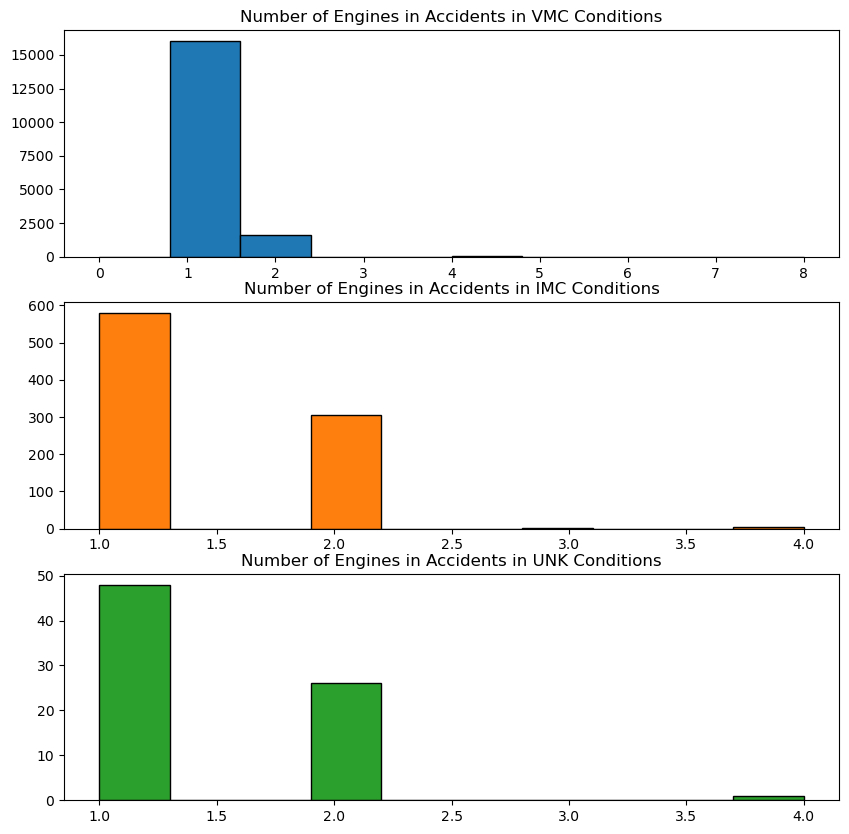

In [711]:
# Are certain types of aircraft more prone to accidents in certain weather conditions?
# create a new figure and set the size
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))


colors = plt.get_cmap('tab10').colors

# loop through each unique weather condition and create a subplot
for i, condition in enumerate(weather_conditions):
    # get data for the specific weather condition
    data = clean_aviation_df[clean_aviation_df['Weather_Condition'] == condition]
    
    # create a subplot and plot data
    ax[i%3].hist(data['Number_of_Engines'], color=colors[i% len(colors)], edgecolor= 'black')
    ax[i%3].set_title(f"Number of Engines in Accidents in {condition} Conditions")

# show the plot
plt.show()

KeyError: "['Air Tractor Inc', 'Aeronca', 'Air Tractor'] not in index"

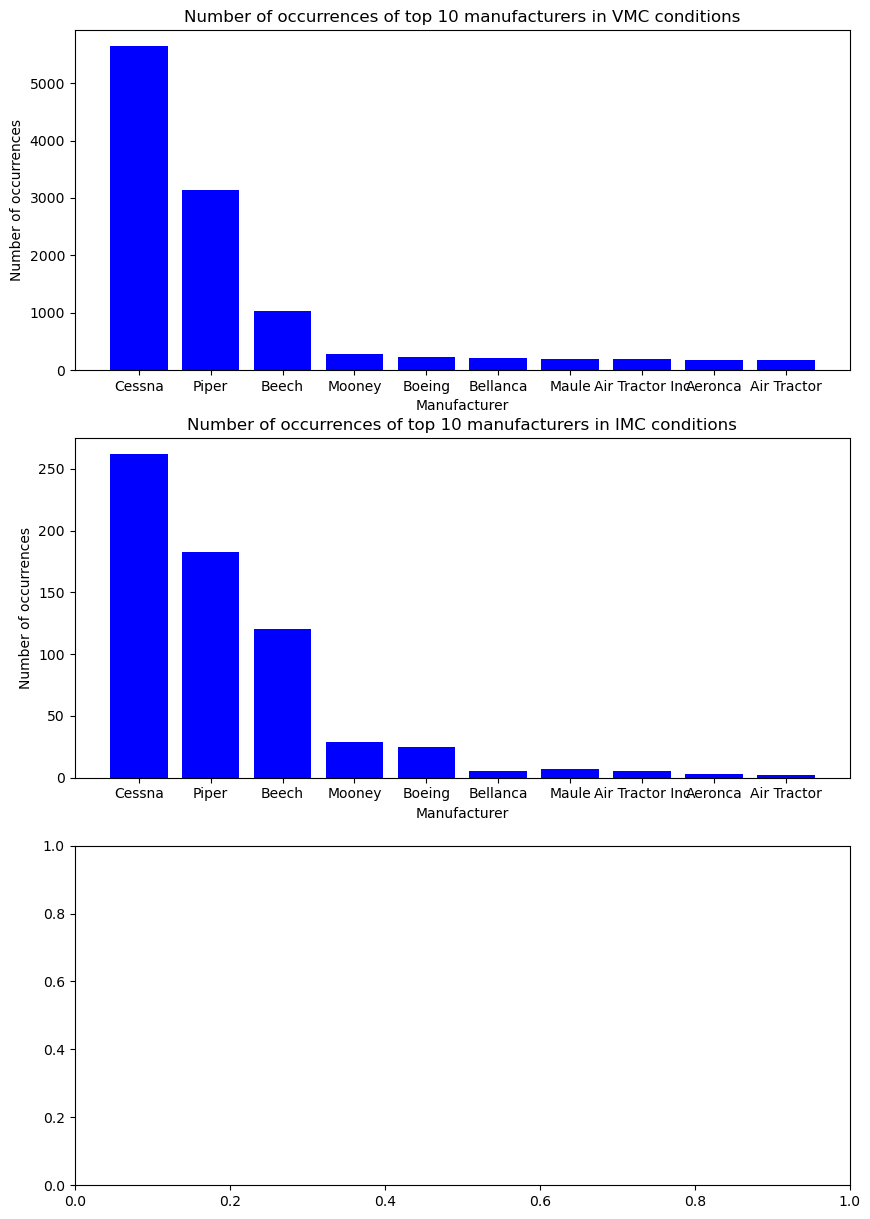

In [863]:
# Create a new figure with 3 rows and 1 column of subplots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Get the top 10 manufacturers
top_10_brands = clean_aviation_df["Make"].value_counts().nlargest(10)

# Loop through each unique weather condition and create a stacked bar chart in a subplot
for i, condition in enumerate(weather_conditions):
    # Get data for the specific weather condition
    data = clean_aviation_df[clean_aviation_df['Weather_Condition'] == condition]

    # Get the value counts for each manufacturer
    value_counts = data['Make'].value_counts().loc[top_10_brands.index]

    # Create a stacked bar chart in the current subplot
    ax[i%3].bar(value_counts.index, value_counts.values, color='b')
    ax[i%3].set_xlabel("Manufacturer")
    ax[i%3].set_ylabel("Number of occurrences")
    ax[i%3].set_title(f"Number of occurrences of top 10 manufacturers in {condition} conditions")

# Show the plot
plt.show()

ValueError: min() arg is an empty sequence

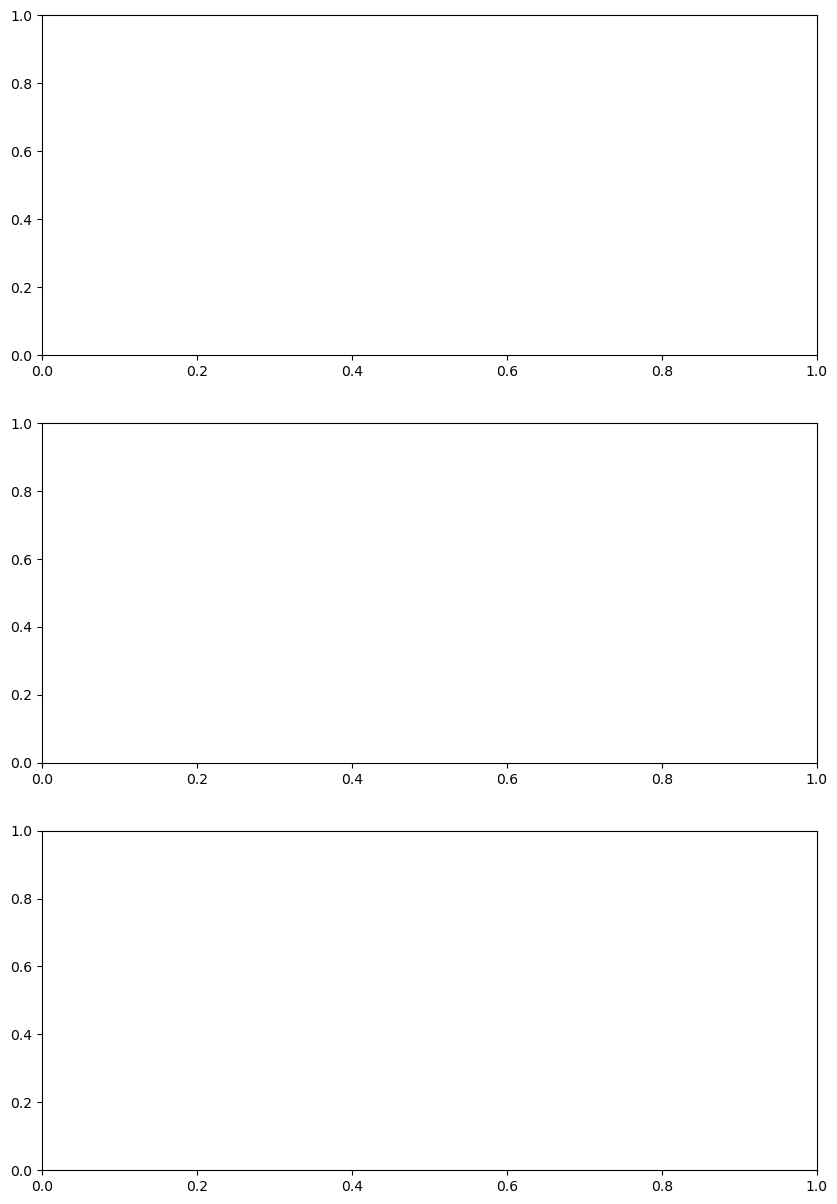

In [859]:
# Create a new figure with 3 rows and 1 column of subplots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

#top_10_brands = clean_aviation_df["Make"].value_counts().nlargest(10)
top_10_brands = clean_aviation_df.groupby(["Number_of_Engines","Weather_Condition","Make"]).size().reset_index(name='counts')
top_10_brands = top_10_brands.sort_values("counts", ascending=False).nlargest(10,"counts")
# Loop through each unique weather condition and create a stacked bar chart in a subplot
for i, condition in enumerate(top_10_brands):
    # Get data for the specific weather condition
    data = clean_aviation_df[clean_aviation_df['Weather_Condition'] == condition]
    
    # Create a stacked bar chart in the current subplot
    sns.barplot(x='Number_of_Engines', y='Make', data=data, ax=ax[i%3], color='b')
    ax[i%3].set_title(f"Number of Engines vs Airplane Brands in {condition} Conditions")

# Show the plot
plt.show()


In [861]:
top_10_brands = clean_aviation_df.groupby(['Make', 'Weather_Condition']).size().sort_values(ascending=False).nlargest(10)

for i, (make, condition) in enumerate(top_10_brands.index):
    data = clean_aviation_df[(clean_aviation_df['Weather_Condition'] == condition) & (clean_aviation_df['Make'] == make)]
    sns.barplot(x='Weather_Condition', y=top_10_brands[i], data=data, ax=ax[i%3], color='b')
    ax[i%3].set_title(f"Number of {make} in {condition} Conditions")

TypeError: cannot unpack non-iterable int object

In [645]:
top_10_brands = clean_aviation_df["Make"].value_counts().nlargest(10)
top_10_brands

Cessna             5919
Piper              3341
Beech              1161
Mooney              309
Boeing              264
Bellanca            207
Maule               195
Air Tractor Inc     191
Aeronca             182
Air Tractor         168
Name: Make, dtype: int64

# What do VMC and IMC mean to the Pilot?

VMC stands for “visual meteorological conditions”, while IMC is “instrument meteorological conditions”.
This graph shows that most accidents happen when pilots are actually piloting the airplane . However, it is also safe to assume that most flights happen when weather conditions are okay.

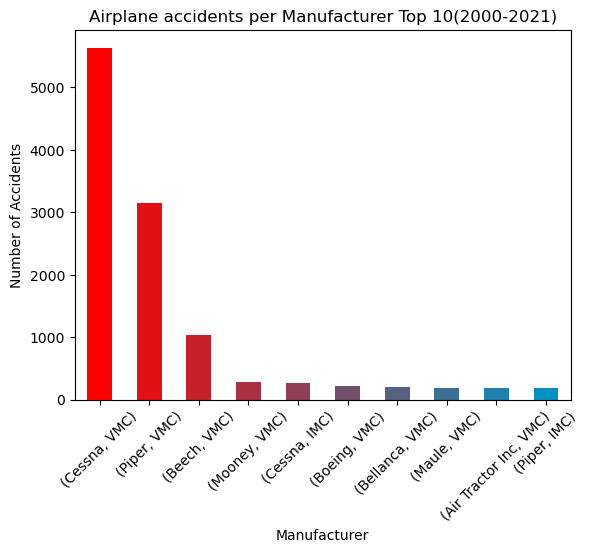

In [864]:
# Are certain types of aircraft more prone to accidents in certain weather conditions?

accidents_by_make = clean_aviation_df.groupby(['Make','Weather_Condition'])['Event_Date'].count().nlargest(10)

colors=['#FF0000', '#0290C0']

accidents_by_make.plot(kind='bar', color=get_color_gradient(colors[0],colors[1], 10))

plt.xticks(rotation=45)
plt.xlabel('Manufacturer')
plt.ylabel('Number of Accidents')
plt.title('Airplane accidents per Manufacturer Top 10(2000-2021)')
plt.savefig('../Images/accidents_per_manufacturer.png')
plt.show()

In [ ]:
# Are certain types of aircraft more prone to accidents in certain weather conditions?
# create a new figure and set the size
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# get unique values for weather conditions
accidents_by_make2 = clean_aviation_df.groupby(['Make','Number_of_Engines','Weather_Condition'])['Event_Date'].count().nlargest(10)

colors = plt.get_cmap('tab10').colors

# loop through each unique weather condition and create a subplot
for i, condition in enumerate(weather_conditions):
    # get data for the specific weather condition
    data = clean_aviation_df[clean_aviation_df['Weather_Condition'] == condition]
    
    # create a subplot and plot data
    ax[i%3].bar(data(['Make','Number_of_Engines']), color=colors[i% len(colors)], edgecolor= 'black')
    ax[i%3].set_title(f"Number of Engines in Accidents in {condition} Conditions")

# show the plot
plt.show()

In [ ]:
# Create a figure and set the subplot layout to 3 rows and 1 column
fig, ax = plt.subplots(3, 1)

# Use the first subplot (at index 0) to plot the number of engines
dfb.groupby("Number_of_Engines").size().plot(kind="bar", ax=ax[0], color='blue')
ax[0].set_title("Number of Engines")

# Use the second subplot (at index 1) to plot the count of accidents by weather condition
dfb.groupby("Weather_Condition").size().plot(kind="bar", ax=ax[1], color='green')
ax[1].set_title("Accidents by Weather Condition")

# Add x-tick labels to the subplots
ax[0].set_xticklabels(dfb["Number_of_Engines"].unique(), rotation=45)
ax[1].set_xticklabels(dfb["Weather_Condition"].unique(), rotation=45)

# Show the plot
plt.show()

In [ ]:
# accidents per year

accidents_per_year = clean_aviation_df.groupby('Year')['Event_Date'].count()

fatal_accidents_per_year = clean_aviation_df[clean_aviation_df['Injury_Severity'] == 'Fatal'].groupby('Year')['Event_Date'].count()

accidents_per_year.plot(label='Total Accidents')
fatal_accidents_per_year.plot(label='Fatal Accidents')
# add a legend
plt.legend()

# add labels and show the plot
plt.xticks(accidents_per_year.index[::2], rotation=90)
plt.xlabel('Years')
plt.ylabel('Accidents')
plt.title('Airplane accidents per Year')
plt.savefig('../Images/accidents_per_year.png')
plt.show()

In [ ]:
clean_aviation_df.loc[clean_aviation_df['Year']==2000]

In [ ]:
#  new dataframe with the percentage of fatal accidents
fatal_accidents_percentage = (fatal_accidents_per_year / accidents_per_year) * 100

# create the line plot
fatal_accidents_percentage.plot(label='Fatal Accidents Percentage')

# add labels and show the plot
plt.xticks(accidents_per_year.index[::2], rotation=90)
plt.xlabel('Year')
plt.ylabel('Fatal Accidents (%)')
plt.title('Fatal Accidents Percentage per Year')
plt.show()

In [ ]:
percentage_total_fatal = (fatal_accidents_per_year.sum()/clean_aviation_df.shape[0])*100
percentage_total_fatal

15.51% of total accidents in the United States are fatal.